In [1]:
# For Data Loading and Engineering
import numpy as np
import pandas as pd
import dask as da
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import multiprocessing as mp
from tqdm import tqdm

# For Visualization
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

import gc

# For Modeling
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
import sklearn

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.utils import class_weight
import linmdtw as ldtw
from linmdtw import dtwgpu

In [2]:
# The csv file is more than 3 gigabytes, while not greater than memory, this method is far, far faster for loading
with ProgressBar():
    input_df = dd.read_csv('input_subset.csv').drop('Link', axis=1).compute(scheduler='processes').set_index(['EPIC','Campaign'], )

[########################################] | 100% Completed | 16.6s


In [3]:
def truncate_samples (df):
    sample_sizes = {x: df.shape[1]-df.xs(x, level=1).iloc[0].isnull().sum() for x in set(df.index.get_level_values('Campaign'))}
    slicepoint = sample_sizes[sorted(sample_sizes, key=sample_sizes.get)[0]]
    return df.drop(columns=list(df.columns[slicepoint:]), inplace=True)

In [4]:
truncate_samples(input_df)

In [5]:
def split_Xy (df):
    X = df[list(df.columns)[1:]]
    y = df['disp']
    return X, y

In [6]:
X, y = split_Xy(input_df)

In [7]:
from hampel import hampel as hampel

In [8]:
gc.collect()

1258

In [9]:
def flux_graph(flux, Window_Size, N, nn, Hampel, Rolling, knn, show_smoothed, E, C, Width, Off, planet):
    a=0
    fig = plt.figure(figsize=(20,5), facecolor=('#1D251E'))
    fig.suptitle(planet, color='white', fontsize=22, y=1.02)
    ax = fig.add_subplot()
    ax.set_facecolor('#303E32')
    ax.set_title('Comparing Denoising Methodology', color='#b4e8bb', fontsize=16)
    ax.set_xlabel('Time \n (Unit: 29.4 minutes)', color='#b4e8bb', fontsize=18)
    ax.set_ylabel('Flux: C' + str(C) + "  " + str(E) , color='white', fontsize=18, loc='center')
    ax.grid(False)
    flux_time = list(flux.index.values.astype(int))
    flux_values = flux
    flux_denoised = flux_values
    if show_smoothed==True:
        a=1
        if ((Hampel==True) & (knn==False)):
            flux_denoised = hampel(flux_values, window_size=Window_Size, n=N, imputation=True)
        elif ((Rolling==True) & (knn==False)):
            flux_denoised = flux_values.rolling(int(Window_Size)).mean()
        elif knn==True:
            X=flux.index.values.astype(int)[:, np.newaxis]
            y=flux_values.transpose()
            clf = KNeighborsRegressor(n_neighbors=int(nn), weights='uniform')
            clf.fit(X, y)
            ypreds = pd.Series(clf.predict(flux.index.values.astype(int)[:, np.newaxis]))
            flux_denoised=ypreds
            if knn==True & Hampel==True:
                flux_denoised = hampel(flux_denoised, window_size=Window_Size, n=N, imputation=True)
            elif knn==True & Rolling==True:
                flux_denoised = flux_denoised.rolling(int(Window_Size)).mean()
    if Rolling:
        nan_mask = flux_denoised.isna()
        flux_denoised.loc[nan_mask] = flux_values.loc[nan_mask]
    x_start = len(flux_values)*Off
    x_end = x_start+len(flux_values)*Width
    ylim_buffer = (abs(max(flux_denoised)-min(flux_denoised)))/10
    ax.plot([i + 1 for i in range(len(flux))], flux_values, '#00ffff', alpha=0.5)
    ax.plot([i + 1 for i in range(len(flux))], flux_denoised, '#e8bbb4', lw=2, alpha=a)
    ax.set_xlim(x_start, x_end)
    ax.set_ylim(min(flux_denoised)-ylim_buffer, max(flux_denoised)+ylim_buffer)
    ax.tick_params(colors = '#b4e8bb', labelcolor='#b4e8bb', labelsize=14)
    plt.show()
    gc.collect()

In [10]:
def show_graph(normalized, dataset, Window_Size, N, nn, is_random, num_graphs, Hampel, Rolling, knn, smooth, Width, Off):
    half_num = round(num_graphs/2)
    if normalized:
        df = pd.concat([dataset['disp'].reset_index(), 
                        pd.DataFrame(normalize(dataset[dataset.columns[1:]], axis=1))], axis=1)\
        .set_index(['EPIC', 'Campaign'])
    else:
        df = dataset
    if is_random:
        with_planet = df[df['disp'] == 1].sample(n=int(num_graphs-half_num)).drop('disp', axis=1)
        wo_planet = df[df['disp'] == 0].sample(n=half_num).drop('disp', axis=1)
    else:
        with_planet = df[df['disp'] == 1].tail(int(num_graphs-half_num)).drop('disp', axis=1)
        wo_planet = df[df['disp'] == 0].tail(half_num).drop('disp', axis=1)
#     print('Smoothing on:', smooth, '\nWhich Method is being used?\nHampel: ', Hampel, '\nRolling Average: ', Rolling, '\nKNearestNeighbors: ', knn)
#     if knn==True:
#         print('\nIf KNearestNeighbors is selected(True), is a second outlier correction applied?\nHampel: ', Hampel, '\nRolling Average:', Rolling)
    for index, row in with_planet.iterrows():
        flux=row
        EPIC=index[0]
        Campain=index[1]
        flux_graph(flux, Window_Size, N, nn, Hampel, Rolling, knn, smooth, EPIC, Campain, Width, Off, planet = 'Planets Present')
    for index, row in wo_planet.iterrows():
        flux=row
        EPIC=index[0]
        Campain=index[1]
        flux_graph(flux, Window_Size, N, nn, Hampel, Rolling, knn, smooth, EPIC, Campain, Width, Off, planet = 'No Planet Present')

In [11]:
def graph_wrapper (df, num_graphs=6, Width=1, Off=0,
                   Standardized=False, Normalized=False, 
                   Random_Selection=False, Noise_Corr='None', Outlier_Corr='None', 
                   Neighbors=20, hampel_n=3, window=25):
    smooth = False
    Hampel = False
    Rolling = False
    knn = False
    if Outlier_Corr == 'None':
        Hampel = False
        Rolling = False
    if Noise_Corr == 'None':
        smooth=False
        Hampel=False
        Rolling=False
    elif Noise_Corr == 'Hampel':
        smooth=True
        Hampel=True
    elif Noise_Corr == 'Rolling':
        smooth=True
        Rolling=True
    elif Noise_Corr == 'Nearest Neighbor':
        knn = True
        smooth=True
        if Outlier_Corr == 'Hampel':
            Hampel=True
            Rolling=False
        elif Outlier_Corr == 'Rolling':
            Hampel=False
            Rolling=True
        else:
            Hampel=False
            Rolling=False

    show_graph (Normalized, df, window, hampel_n, Neighbors, Random_Selection, num_graphs, Hampel, Rolling, knn, smooth, Width, Off)

# Taking a look at the Data and considering ways to denoise/transform it

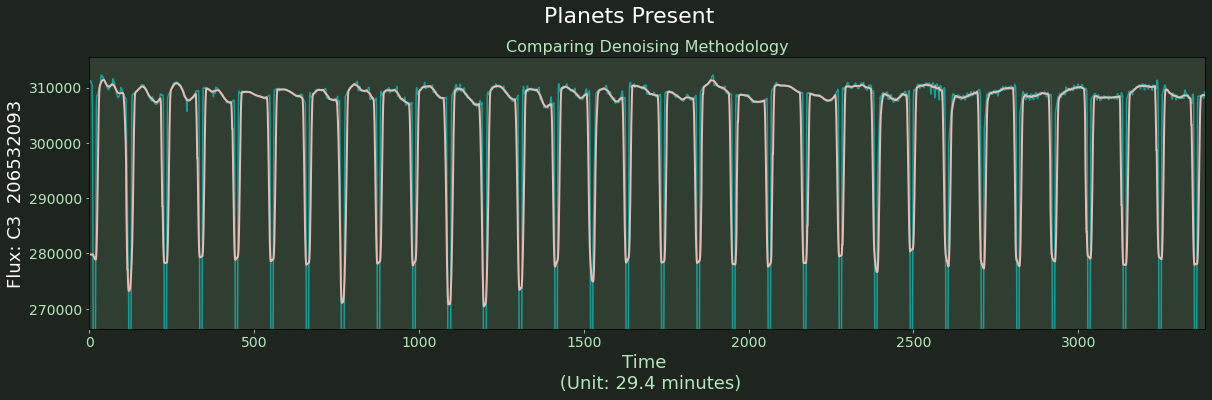

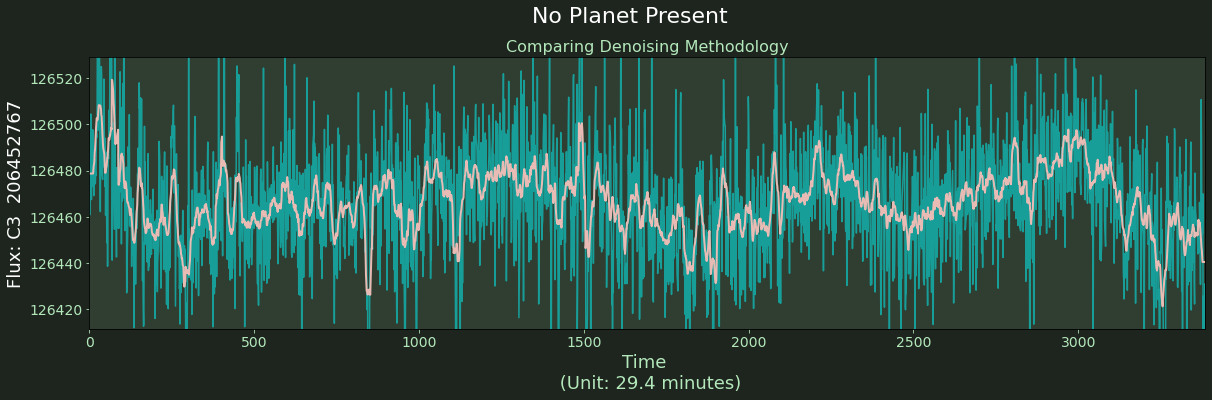

In [12]:
graph_wrapper(input_df, Noise_Corr='Nearest Neighbor', Random_Selection=False, num_graphs=2)

# The Process:

# Cluster 
#### Clutser the majority class into k clusters
(Where k = minority class population size

# Scale
#### Standardize the scale for modeling

# Model
#### Use KNN=1 Modeling for Classification

# How Do I Cluster Time Series Data? #

$$W^*=argmin_W(\sqrt{\sum_{k=1}^Kw_k})$$

In [15]:
def DTWDistance(flux1, flux2):
    #inputs are two lightcurves (flux1, flux2) and a window (w), consider the window a means of more quickly running through th
    # in case the two flux curve lengths are different remember this is DTW which can read in differing length time series
#     w = max(w, abs(len(flux1)-len(flux2)))
    #build a matrix size M,N and fill it with float zeros
    DTW = np.zeros((len(flux2), len(flux1)))
#     for i in range(-1, len(flux1)):
#         for j in range(-1, len(flux2)):
#             DTW[(i,j)] = float('inf')
#     DTW[(-1, -1)] = 0
    for i in range(1, len(flux2)):
#         for j in range(max(0, i-w), min(len(flux2), i+w)):
        for j in range(1, len(flux1)):
            dist = (flux1[j]-flux2[i])**2
            DTW[i, j] = dist + min(DTW[i-1, j], DTW[i, j-1], DTW[i-1, j-1])
    #Return the "similarit score" or "cost" as the length of the shortest warping path through the Distance Matrix
    return DTW, DTWPath(DTW, flux1, flux2), np.sqrt(DTW[len(flux1)-1, len(flux2)-1])

In [39]:
def DTWVectorized(flux1, flux2):
    dist_mat = np.transpose((flux1-flux2.T)**2)
    DTW_mat = np.full((len(flux1), len(flux2)), np.inf)
    x, y = np.array(dist_mat.shape)-1
    diag_idx = np.append(np.tril(np.tile(np.arange(0, x), (y,1))+1), np.triu((x+1)-np.fliplr(np.tril(np.tile(np.arange(0, x), (y,1))+1))[::-1])[1:], axis=0)
    DTW_mat[0,0] = dist_mat[0,0]
    idx = np.arange(1, len(flux1))
    DTW_mat[0,idx] = dist_mat[0,idx] + np.cumsum(dist_mat[0,:], axis=0)[:-1]
    DTW_mat[idx,0] = dist_mat[idx,0] + np.cumsum(dist_mat[:,0], axis=0)[:-1]
    def f (i):
        I = i
        J = cp.flip(I)
        DTW_mat[I[I!=0], J[J!=0]] = dist_mat[I[I!=0], J[J!=0]] + np.minimum(np.minimum(DTW_mat[I[I!=0]-1, J[J!=0]-1], DTW_mat[I[I!=0]-1, J[J!=0]]), DTW_mat[I[I!=0], J[J!=0]-1])
    np.apply_along_axis(f, 1, diag_idx)
    return DTW_mat, DTWPath(DTW_mat, flux1, flux2), np.sqrt(DTW_mat[len(flux1)-1, len(flux2)-1])

In [17]:
def DTWPath(DTWMatrix, flux1, flux2):
    path = [[len(flux1)-1, len(flux2)-1]]    
    i = len(flux2)-1
    j = len(flux1)-1
    
    while i>0 and j>0:
        if i==0:
            j = j - 1
        elif j==0:
            i = i - 1
        else:
            if DTWMatrix[i-1, j] == min(DTWMatrix[i-1, j-1], DTWMatrix[i-1, j], DTWMatrix[i, j-1]):
                i = i - 1
            elif DTWMatrix[i, j-1] == min(DTWMatrix[i-1, j-1], DTWMatrix[i-1, j], DTWMatrix[i, j-1]):
                j = j-1
            else:
                i = i - 1
                j = j- 1
        path.append([j, i])
    path.append([0,0])
    return path

In [18]:
def distance_cost_plot(distances, path, d, f1, f2, c1, c2):
    path_x = [point[0] for point in path]
    path_y = [point[1] for point in path]

    fig = plt.figure(figsize=(20,20), facecolor=('#1D251E'))
    im = plt.imshow(distances, interpolation='nearest', cmap='Reds')
    plt.title('DTW Distance = ' + str(d), color='#b4e8bb', fontsize=24)
    plt.gca().invert_yaxis()
    plt.xlabel('C'+ str(c1) + ' '+ str(f1), color='white', fontsize=18)
    plt.ylabel('C'+ str(c2) + ' '+ str(f2), color='white', fontsize=18)
    plt.tick_params(color = '#b4e8bb', labelcolor='#b4e8bb', labelsize=14)
    plt.grid(False)
    cb = plt.colorbar(im);
    cb.ax.yaxis.set_tick_params(color='#b4e8bb', labelcolor='#b4e8bb')
    plt.plot(path_x, path_y, lw=5)

In [19]:
import cupy as cp
from cuml import KMeans

In [44]:
def warp_plot(planet=True, normalized=False, samesame=True):
    from tslearn.utils import to_time_series
    heatmap_data = input_df.loc[input_df['disp']==planet].sample(n=2)
    flux1_epic = heatmap_data.index.values[0][0]
    flux1_c = heatmap_data.index.values[0][1]
    flux2_epic = heatmap_data.index.values[1][0]
    flux2_c = heatmap_data.index.values[1][1]
    heatmap_data.drop('disp', axis=1, inplace=True)
    heatmap_data = np.apply_along_axis(to_time_series, 1, heatmap_data.values)
 
    flux1 = heatmap_data[0,:,:]
    flux2 = heatmap_data[1,:,:]
    
    flux1
    if samesame:
        flux2 = flux1
        flux2_epic = flux1_epic
        flux2_c = flux1_c
    if normalized:
        scaler = StandardScaler()
        flux1 = scaler.fit_transform(flux1)
        flux2 = scaler.fit_transform(flux2)
    
    import time
    start = time.process_time()
    DTW_M, DTW_P, DTW_D = DTWVectorized(flux1, flux2)
    print("My Vectorized DTW Run Time:", time.process_time() - start)
    
    start = time.process_time()
    test = ldtw.fastdtw(flux1.T, flux2.T, 30)
    print("Imported Fast Linear Memory DTW Run Time:",time.process_time() - start)
    
    distance_cost_plot(DTW_M, DTW_P, DTW_D, flux1_epic, flux2_epic, flux1_c, flux2_c)

# The Floor is Lava!

My Vectorized DTW Run Time: 0.7884511999999972


/home/john/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/linmdtw/dtw.py:40: UserWarning: X is not 32-bit, so creating 32-bit version
  warnings.warn("X is not 32-bit, so creating 32-bit version")
/home/john/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/linmdtw/dtw.py:46: UserWarning: Y is not 32-bit, so creating 32-bit version
  warnings.warn("Y is not 32-bit, so creating 32-bit version")
/home/john/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/linmdtw/dtw.py:43: UserWarning: X is not C-contiguous; creating a copy that is C-contiguous
  warnings.warn("X is not C-contiguous; creating a copy that is C-contiguous")
/home/john/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/linmdtw/dtw.py:49: UserWarning: Y is not C-contiguous; creating a copy that is C-contiguous
  warnings.warn("Y is not C-contiguous; creating a copy that is C-contiguous")


Imported Fast Linear Memory DTW Run Time: 1.3405559999999994


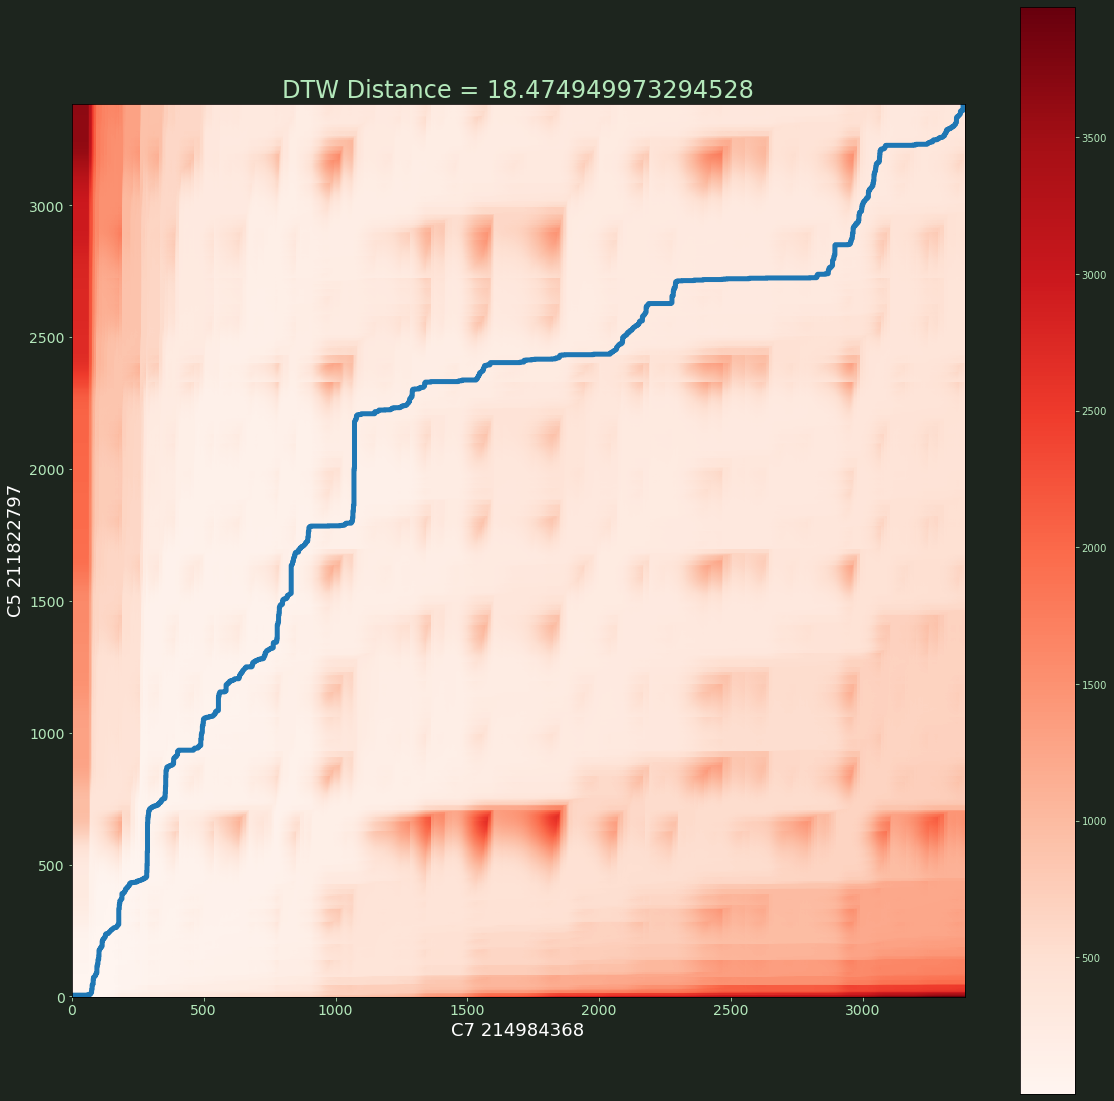

In [45]:
warp_plot(planet=True, normalized=True, samesame=False)

# How to make this faster:

## In steps LB Keogh

This is a much faster way to tell if it is even worth checking what the DTW Cost is. Consider it a lower limit of what the 'distance' *could* be. You use this lower bound as a filter. 


$$ LB Keogh(Q,C)=\sum_{i=1}^n (c_i-U_i)^2I(c_i > U_i)+(c_i-L_i)^2I(c_i < L_i) $$

In [17]:
def LB_Keogh(flux1, flux2, r): 
    #inputs are two lightcurves (flux1, flux2) and a 'reach' distance (r)
    #input light curve dtypes should be np arrays for sake of speed when indexing sing the inputs are already aligned
    
    #initialize your squared score variable
    LB_score_squared=0
    
    #begin stepping through flux values
    for index, flux in enumerate(flux1):
        
        #establish minum and maximum range in second light curve looking at index - reach : index + reach
        lower_bound = min(flux2[(index-r if index-r>=0 else 0):(index + r)])
        upper_bound = max(flux2[(index-r if index-r>=0 else 0):(index + r)])

        #add a penalty to the squared score if the flux value is outside the established range
        if flux > upper_bound:
            LB_score_squared = LB_score_squared+(flux-upper_bound)**2
        elif flux < lower_bound:
            LB_score_squared = LB_score_squared+(flux-lower_bound)**2

    #return the LB Keough score
    return np.sqrt(LB_score_squared)

# Do a K-Means Clustering on the Majority Class where the number of output clusters is equal to the number of the Minority Class
### Utilizing the DTW as the distance metric, and speeing up the checking process via LB Keogh filtration

In [46]:
def k_means_clust(data, num_clust, num_iter, r=5, random_seed=1234):
    np.random.seed(random_seed)
    random_rows = np.random.choice(len(data), size=num_clust, replace=False)
    centroids = data[random_rows,:,:]
    for n in range(num_iter):
        assignments={}
        bar1 = tqdm(total=len(data))
        for index, flux1 in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_index, flux2 in enumerate(centroids):
                if LB_Keogh(flux1, flux2, 5) < min_dist:
                    path, cur_dist = DTWVectorized(flux1, flux2)
                    if cur_dist < min_dist:
                        min_dist = cur_dist
                        closest_clust = c_index
            if closest_clust in assignments:
                assignments[closest_clust].append(index)
            else:
                assignments[closest_clust]=[]
            bar1.update()
        for key in assignments:
            clust_sum = 0
            for k in assignments[key]:
                clust_sum = clust_sum + data[k]
            centroids[key] = [m/len(assignments[key]) for m in clust_sum]

    return centroids

# Realize that smarter people have already figured this stuff out

In [ ]:
from tslearn.clustering import TimeSeriesKMeans

In [ ]:
# Build Majority and Minority Class as separate DataFrames
majority_class = input_df.loc[input_df['disp']==0,:].drop('disp', axis=1)
minority_class = input_df.loc[input_df['disp']==1,:].drop('disp', axis=1)

# Convert the Majority Class values to a nd array of tslearn time series
from tslearn.utils import to_time_series
X = np.apply_along_axis(to_time_series, 1, majority_class_ds.values)

# Instantiate our K-Means model with DTW as the metric and generate the centroids via Barycenter Averaging
TSKM = TimeSeriesKMeans(n_clusters=len(minority_class), verbose=True, max_iter=3, metric='dtw', n_jobs=-1, max_iter_barycenter=3)


# TSKM.fit(X)

# Cry

# Swallow Pride and completely downsample everything by a factor of 10.

## Then resample the data so that the imbalance is *ONLY* 10:1

In [ ]:
majority_class_ds = majority_class.sample(n=round(len(majority_class)/10))
minority_class_ds = minority_class.sample(n=round(len(minority_class)/10))

In [ ]:
np.random.seed(1234)
random_rows = np.random.choice(len(X), size=len(minority_class), replace=False)
X_Sampled = X[random_rows,:,:]

In [ ]:
TSKM = TimeSeriesKMeans(n_clusters=len(minority_class), verbose=True, max_iter=3, metric='dtw', n_jobs=-1, max_iter_barycenter=3)

# TSKM.fit(X)

Thank you.